# **In this notebook I will test 2 ML models: Random forest & XGBoost**
### I will try diffrent external features to see a direction to fined the best features 

In [1]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict

### Funcion to evaluate each model I am trying

In [15]:
def regressionMetrics(y, yhat):
    res = {
        'MSE': metrics.mean_squared_error(y, yhat),
        'RMSE': np.sqrt(metrics.mean_squared_error(y, yhat)),
        'MAE': metrics.mean_absolute_error(y, yhat),
        'R2': metrics.r2_score(y, yhat)
    }

    # Check if all values are > -1 to safely apply log
    if np.all(y > -1) and np.all(yhat > -1):
        rmsle = np.sqrt(metrics.mean_squared_log_error(y, yhat))
        res['RMSLE'] = rmsle
    else:
        res['RMSLE'] = 'Not applicable (values ≤ -1)'

    return res

In [4]:
import sys
import numpy.core.numeric as new_numeric

# Create a fake module under the old name because of env conflict
sys.modules['numpy._core.numeric'] = new_numeric


directory = 'raw_files'
df = pd.read_pickle(rf'{directory}/data_for_model')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2082 non-null   datetime64[ns]
 1   SPY_return           2082 non-null   float64       
 2   SPY_Volume           2082 non-null   float64       
 3   AAPL                 2082 non-null   float64       
 4   MSFT                 2082 non-null   float64       
 5   GOOG                 2082 non-null   float64       
 6   GLD                  2082 non-null   float64       
 7   SLV                  2082 non-null   float64       
 8   ^TNX                 2082 non-null   float64       
 9   DX-Y.NYB             2082 non-null   float64       
 10  JPY=X                2082 non-null   float64       
 11  EUR=X                2082 non-null   float64       
 12  USO                  2082 non-null   float64       
 13  UNG                  2082 non-nul

# This section is if yahoo limited the data extraction:

In [ ]:
#c = pd.read_pickle('combined_cleaned_add.pkl')

#c.reset_index( inplace=True)   
#c.rename(columns={'Date':'ds'}, inplace=True)
#c.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2084 non-null   datetime64[ns]
 1   SPY_Close            2084 non-null   float64       
 2   SPY_Volume           2084 non-null   int64         
 3   AAPL                 2084 non-null   float64       
 4   MSFT                 2084 non-null   float64       
 5   GOOG                 2084 non-null   float64       
 6   GLD                  2084 non-null   float64       
 7   SLV                  2084 non-null   float64       
 8   ^TNX                 2084 non-null   float64       
 9   DX-Y.NYB             2084 non-null   float64       
 10  JPY=X                2084 non-null   float64       
 11  EUR=X                2084 non-null   float64       
 12  USO                  2084 non-null   float64       
 13  UNG                  2084 non-nul

In [ ]:

#add_l = ['ds','2Y_Yield','^TNX','yield_curve'] # I will add thoes values later
#re_list = ['market_closed_count','yield_curve_term','high-low','before_high-low'] 
#add_later = c[add_l]
#add_later = add_later.rename(columns={'2Y_Yield':'abs_2Y_Yield','^TNX':'10y_yield','yield_curve':'abs_yield_curve'}) # I want to have abs value and presantage change for thoes fetures
#c = c.drop(re_list,axis=1)
#add_later.head()

,ds,abs_2Y_Yield,10y_yield,abs_yield_curve
0,2017-01-03,1.22,2.450,1.230
1,2017-01-04,1.24,2.452,1.212
2,2017-01-05,1.17,2.368,1.198
3,2017-01-06,1.22,2.418,1.198
4,2017-01-09,1.21,2.376,1.166


In [ ]:
#df = df.merge(add_later, on='ds', how='left')
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2082 non-null   datetime64[ns]
 1   SPY_return           2082 non-null   float64       
 2   SPY_Volume           2082 non-null   float64       
 3   AAPL                 2082 non-null   float64       
 4   MSFT                 2082 non-null   float64       
 5   GOOG                 2082 non-null   float64       
 6   GLD                  2082 non-null   float64       
 7   SLV                  2082 non-null   float64       
 8   ^TNX                 2082 non-null   float64       
 9   DX-Y.NYB             2082 non-null   float64       
 10  JPY=X                2082 non-null   float64       
 11  EUR=X                2082 non-null   float64       
 12  USO                  2082 non-null   float64       
 13  UNG                  2082 non-nul

In [5]:
model_lst = pd.DataFrame()

In [6]:
# print all of the columns in the dataframe
print(df.columns.to_list())

['ds', 'SPY_return', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_Streak', 'SPY_AbsChange', 'day', 'month']


# The start of modeling
### I will try Random forrest & XGboost on return data only : I found them to be more accurate when predicting returns instead of absolute values
### this is just the start, and not the final model, the final model will be displayed in the next notebook

In [7]:
y = df['SPY_return']
x = df.drop(['SPY_return', 'ds'], axis=1)


In [8]:
print(x.columns.to_list())

['SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_Streak', 'SPY_AbsChange', 'day', 'month']


In [9]:
# make sure I dont have andesired data types
x.info()
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Volume           2082 non-null   float64
 1   AAPL                 2082 non-null   float64
 2   MSFT                 2082 non-null   float64
 3   GOOG                 2082 non-null   float64
 4   GLD                  2082 non-null   float64
 5   SLV                  2082 non-null   float64
 6   ^TNX                 2082 non-null   float64
 7   DX-Y.NYB             2082 non-null   float64
 8   JPY=X                2082 non-null   float64
 9   EUR=X                2082 non-null   float64
 10  USO                  2082 non-null   float64
 11  UNG                  2082 non-null   float64
 12  BTC-USD              2082 non-null   float64
 13  CPER                 2082 non-null   float64
 14  ^VIX                 2082 non-null   float64
 15  ^GDAXI               2082 non-null   f

C:\Users\OMER\AppData\Local\Temp\ipykernel_18676\1679072723.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x.fillna(method='ffill', inplace=True)


In [10]:
# split the data
split = int(len(y)*0.9)
x_train = x.iloc[:split]
x_test = x.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [11]:
df[['ds','SPY_return']].tail(20)

,ds,SPY_return
2062,2025-03-20,-0.218489
2063,2025-03-21,0.082465
2064,2025-03-24,1.764600
2065,2025-03-25,0.157433
2066,2025-03-26,-1.115693
2067,2025-03-27,-0.330698
2068,2025-03-28,-1.973722
2069,2025-03-31,0.553852
2070,2025-04-01,0.378124
2071,2025-04-02,0.672819


In [12]:
# Find rows with inf or -inf
mask_inf = x_train.isin([np.inf, -np.inf])
rows_with_inf = x_train[mask_inf.any(axis=1)]
print("Rows with inf/-inf:")
print(rows_with_inf)

Rows with inf/-inf:
Empty DataFrame
Columns: [SPY_Volume, AAPL, MSFT, GOOG, GLD, SLV, ^TNX, DX-Y.NYB, JPY=X, EUR=X, USO, UNG, BTC-USD, CPER, ^VIX, ^GDAXI, ^FTSE, ^RUT, ^N225, IEI, CNYUSD=X, 2Y_Yield, yield_curve, market_closed_count, yield_curve_term, high-low, before_high-low, SPY_Streak, SPY_AbsChange, day, month]
Index: []

[0 rows x 31 columns]


In [13]:
model_rf = RandomForestRegressor(n_jobs=-1)
model_rf.fit(x_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
predicted_rf = model_rf.predict(x_test)
regressionMetrics(y_test,predicted_rf)

{'MSE': 0.14872247509360345,
 'RMSE': 0.38564553036902094,
 'MAE': 0.26979631479583416,
 'R2': 0.9090456467246546,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [17]:
model_dict = {'model': 'regular random foresrt'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test,predicted_rf)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.148722,0.385646,0.269796,0.909046,Not applicable (values ≤ -1)


### Show actual return vs the predicted:

In [24]:
check_df = pd.concat([y_test, pd.Series(predicted_rf, index=y_test.index)], axis=1)
check_df.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df.tail(20)


,Actual,Predicted
2062,-0.218489,-0.346845
2063,0.082465,0.197133
2064,1.764600,1.241066
2065,0.157433,0.308169
2066,-1.115693,-1.087491
2067,-0.330698,-0.200340
2068,-1.973722,-2.075150
2069,0.553852,-0.507386
2070,0.378124,0.506400
2071,0.672819,0.646575


**Plot:**

<Axes: xlabel='Actual', ylabel='Predicted'>

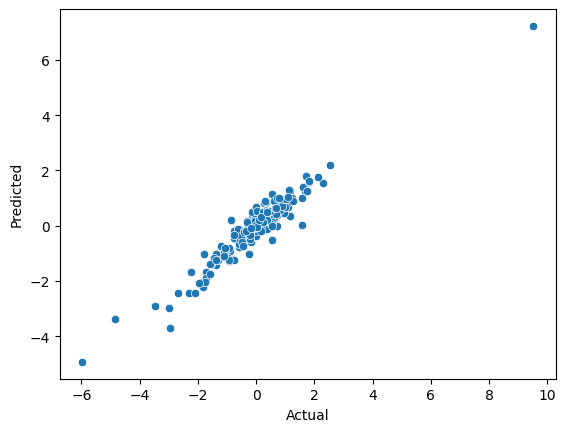

In [19]:
import seaborn as sns
sns.scatterplot(x=check_df['Actual'], y=check_df['Predicted'])

**Convert to absoulut value and show prediction**

I did not use the real prices, all I wanted to see the the overall trent and the prediction performance

In [25]:
check_df['price_actual'] = 300 * (1 + check_df['Actual'] / 100).cumprod()
check_df['price_predicted'] = 300 * (1 + check_df['Predicted'] / 100).cumprod()


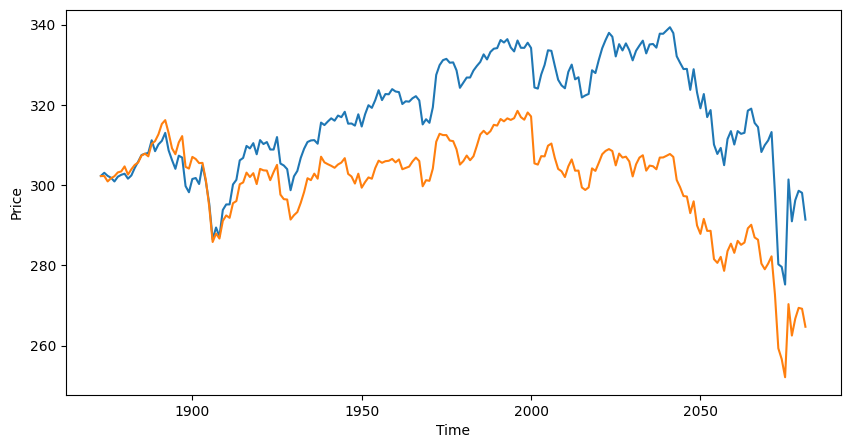

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(check_df['price_actual'], label='Actual Price')
plt.plot(check_df['price_predicted'], label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Seems desent , but can be way better

In [28]:
#save as df for demo:
check_df1 = check_df[['price_actual','price_predicted']]
check_df1.rename(columns = {'price_actual':'Actual','price_predicted':'predicted'}, inplace=True)
check_df1.to_csv(rf'{directory}/random_forest.csv')

C:\Users\OMER\AppData\Local\Temp\ipykernel_18676\2279457751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df1.rename(columns = {'price_actual':'Actual','price_predicted':'predicted'}, inplace=True)


## With cross validation
cross validation is not better, cross validation does not work well on Timeseries data 

In [21]:
check_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 1873 to 2081
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Actual           209 non-null    float64
 1   Predicted        209 non-null    float64
 2   price_actual     209 non-null    float64
 3   price_predicted  209 non-null    float64
dtypes: float64(4)
memory usage: 6.7 KB


In [22]:
model_cv_rf = RandomForestRegressor(n_jobs=-1)
pred_cv = cross_val_predict(model_cv_rf,x_test,y_test,cv=5)

In [23]:
regressionMetrics(y_test,pred_cv)

{'MSE': 0.514445631296849,
 'RMSE': np.float64(0.7172486537434901),
 'MAE': 0.36956259422167215,
 'R2': 0.6853799692314013,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# XGBoost

In [24]:
xg = xgb.XGBRegressor(n_jobs =-1 )
xg.fit(x_train, y_train)
predicted_xg = xg.predict(x_test)
regressionMetrics(y_test,predicted_xg)

{'MSE': 0.1759080753146052,
 'RMSE': np.float64(0.41941396652305846),
 'MAE': 0.3056977910801751,
 'R2': 0.8924197219278339,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [25]:
model_dict = {'model': 'regular xgboost'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test,predicted_xg)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)


# Add events 
I am adding external economic events 

In [26]:
#df['ds'].head()
event = pd.read_pickle('SPY_with_events.pkl')
#event = pd.read_csv('cpi_release_dates_2020_2025.csv')
event.head(20)

,ds,SPY_Close,SPY_Volume,month,day,Actual_GDP,Actual_nonfarm,Actual_CPI,Actual_PPI,Actual_unemployment rate,...,nonfarm_vs_previous,unemployment rate_vs_forecast,unemployment rate_vs_previous,core_PCE_vs_forecast,core_PCE_vs_previous,FOMC_vs_forecast,FOMC_vs_previous,is_event,days_since_fomc,isr_holiday
0,2017-01-03,2257.830078,3773010000,1,3,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,2017-01-04,2270.750000,3768890000,1,4,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2,2017-01-05,2269.000000,3785080000,1,5,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,2017-01-06,2276.979980,3342080000,1,6,none event,156K,none event,none event,0.047,...,-1.0,0.0,1.0,NaN,NaN,NaN,NaN,1,NaN,0
4,2017-01-09,2268.899902,3219730000,1,9,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
5,2017-01-10,2268.899902,3640560000,1,10,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
6,2017-01-11,2275.320068,3625080000,1,11,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
7,2017-01-12,2270.439941,3466220000,1,12,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
8,2017-01-13,2274.639893,3090680000,1,13,none event,none event,none event,0.016,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0
9,2017-01-17,2267.889893,3586950000,1,17,none event,none event,none event,none event,none event,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [27]:
event['is_event'].head(20)

0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     1
9     0
10    1
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    1
19    0
Name: is_event, dtype: int64

# Add column for the name of the event

In [28]:
lst_cols =['Actual_GDP','Actual_nonfarm','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
def identify_events(row):
    events = [col for col in lst_cols if row[col] != 'none event']
    return ', '.join(events) if events else np.nan

event['event'] = event.apply(identify_events, axis=1)

event['event'].head(20)

0                                          NaN
1                                          NaN
2                                          NaN
3     Actual_nonfarm, Actual_unemployment rate
4                                          NaN
5                                          NaN
6                                          NaN
7                                          NaN
8                                   Actual_PPI
9                                          NaN
10                                  Actual_CPI
11                                         NaN
12                                         NaN
13                                         NaN
14                                         NaN
15                                         NaN
16                                         NaN
17                                  Actual_GDP
18                             Actual_core_PCE
19                                         NaN
Name: event, dtype: object

# Encode the events

In [29]:
event['event'] = event['event'].astype('category')
event['event'] = event['event'].cat.codes
event['event'].head(20)

0    -1
1    -1
2    -1
3     9
4    -1
5    -1
6    -1
7    -1
8     6
9    -1
10    0
11   -1
12   -1
13   -1
14   -1
15   -1
16   -1
17    3
18    8
19   -1
Name: event, dtype: int8

In [30]:
# DATE TO ds
event=  event.rename(columns={'Date':'ds'})
event['ds'] = pd.to_datetime(event['ds'],format='%Y-%m-%d')

In [31]:
event_ = event.drop(['SPY_Close','SPY_Volume','month','day'],axis=1)
event_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2086 non-null   datetime64[ns]
 1   Actual_GDP                     2086 non-null   object        
 2   Actual_nonfarm                 2086 non-null   object        
 3   Actual_CPI                     2086 non-null   object        
 4   Actual_PPI                     2086 non-null   object        
 5   Actual_unemployment rate       2086 non-null   object        
 6   Actual_core_PCE                2086 non-null   object        
 7   Actual_FOMC                    2086 non-null   object        
 8   CPI_vs_forecast                97 non-null     float64       
 9   CPI_vs_previous                97 non-null     float64       
 10  GDP_vs_forecast                98 non-null     float64       
 11  GDP_vs_previous  

Handle some external data data type - need to convert 63k to 63 or 63000

In [32]:
def convert_k_to_number(val):
    if isinstance(val, str) and 'k' in val.lower():
        try:
            return float(val.lower().replace('k', '')) * 1000
        except:
            return val
    return val  # return as-is if already numeric or not a string

event_['Actual_nonfarm'] = event_['Actual_nonfarm'].apply(convert_k_to_number)
event_['Actual_nonfarm'] = pd.to_numeric(event_['Actual_nonfarm'], errors='coerce')

event_.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2086 non-null   datetime64[ns]
 1   Actual_GDP                     2086 non-null   object        
 2   Actual_nonfarm                 93 non-null     float64       
 3   Actual_CPI                     2086 non-null   object        
 4   Actual_PPI                     2086 non-null   object        
 5   Actual_unemployment rate       2086 non-null   object        
 6   Actual_core_PCE                2086 non-null   object        
 7   Actual_FOMC                    2086 non-null   object        
 8   CPI_vs_forecast                97 non-null     float64       
 9   CPI_vs_previous                97 non-null     float64       
 10  GDP_vs_forecast                98 non-null     float64       
 11  GDP_vs_previous  

In [33]:
event_['Actual_nonfarm'].fillna('none event', inplace=True)
event_['Actual_nonfarm'].head(20)

C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\3214170230.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_['Actual_nonfarm'].fillna('none event', inplace=True)
C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\3214170230.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'none event' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  event_['Actual_nonfarm'].fillna('none event', inplace=True)


0     none event
1     none event
2     none event
3       156000.0
4     none event
5     none event
6     none event
7     none event
8     none event
9     none event
10    none event
11    none event
12    none event
13    none event
14    none event
15    none event
16    none event
17    none event
18    none event
19    none event
Name: Actual_nonfarm, dtype: object

In [34]:
event_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2086 non-null   datetime64[ns]
 1   Actual_GDP                     2086 non-null   object        
 2   Actual_nonfarm                 2086 non-null   object        
 3   Actual_CPI                     2086 non-null   object        
 4   Actual_PPI                     2086 non-null   object        
 5   Actual_unemployment rate       2086 non-null   object        
 6   Actual_core_PCE                2086 non-null   object        
 7   Actual_FOMC                    2086 non-null   object        
 8   CPI_vs_forecast                97 non-null     float64       
 9   CPI_vs_previous                97 non-null     float64       
 10  GDP_vs_forecast                98 non-null     float64       
 11  GDP_vs_previous  

# Handle nulls
I will try few approches

The best that I found is the one bellow

# This is the best method

In [60]:
#1 : nuls = -10 & none event =-10
event_1 = event_.copy()
#for col in event_1.select_dtypes('object').columns:
    #event_1[col] = pd.to_numeric(event_1[col], errors='coerce')
event_1 = event_1.fillna(-5)
lst_col = ['Actual_GDP','Actual_nonfarm','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
for col in lst_col:
    event_1[col] = event_1[col].replace('none event',-5)

event_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2086 non-null   datetime64[ns]
 1   Actual_GDP                     2086 non-null   float64       
 2   Actual_nonfarm                 2086 non-null   float64       
 3   Actual_CPI                     2086 non-null   float64       
 4   Actual_PPI                     2086 non-null   float64       
 5   Actual_unemployment rate       2086 non-null   float64       
 6   Actual_core_PCE                2086 non-null   float64       
 7   Actual_FOMC                    2086 non-null   float64       
 8   CPI_vs_forecast                2086 non-null   float64       
 9   CPI_vs_previous                2086 non-null   float64       
 10  GDP_vs_forecast                2086 non-null   float64       
 11  GDP_vs_previous  

C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\113293629.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_1[col] = event_1[col].replace('none event',-5)


In [ ]:
# optional: use only the event name, if there was an event on a certain day and holidays 
#event_1 = event_1[['ds','event','is_event','isr_holiday']]

In [ ]:
#2 : nulls =-10 & forward fill for the nonde event
#event_2 = event_.copy()
#event_2 = event_2.fillna(-10)
#for col in lst_col:
#    event_2[col] = event_2[col].replace('none event', np.nan)  # convert to NaN first
#    event_2[col] = pd.to_numeric(event_2[col], errors='coerce')  # make sure all values are numeric
#    event_2[col] = event_2[col].ffill()  # forward-fill the last known value

#event_2 = event_2.dropna()
#event_2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1305 entries, 20 to 1324
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             1305 non-null   datetime64[ns]
 1   Actual_GDP                     1305 non-null   float64       
 2   Actual_nonfarm                 1305 non-null   float64       
 3   Actual_CPI                     1305 non-null   float64       
 4   Actual_PPI                     1305 non-null   float64       
 5   Actual_unemployment rate       1305 non-null   float64       
 6   Actual_core_PCE                1305 non-null   float64       
 7   Actual_FOMC                    1305 non-null   float64       
 8   CPI_vs_forecast                1305 non-null   float64       
 9   CPI_vs_previous                1305 non-null   float64       
 10  GDP_vs_forecast                1305 non-null   float64       
 11  GDP_vs_previous      

C:\Users\OMER\AppData\Local\Temp\ipykernel_20628\582652171.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_2[col] = event_2[col].replace('none event', np.nan)  # convert to NaN first


In [ ]:
#3: both forward fill
#event_3 = event_.copy()
#event_3 = event_3.ffill()
#for col in lst_col:
#    event_3[col] = event_3[col].replace('none event', np.nan)  # convert to NaN first
#    event_3[col] = pd.to_numeric(event_3[col], errors='coerce')  # make sure all values are numeric
#    event_3[col] = event_3[col].ffill()  # forward-fill the last known value
#lst_col = ['Actual_GDP','Actual_nonfarm','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
#for col in lst_col:
#    event_3[col] = event_3[col].replace('none event',-10)


#event_3 = event_3.dropna()
#event_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1311 entries, 19 to 1329
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             1311 non-null   datetime64[ns]
 1   Actual_GDP                     1311 non-null   float64       
 2   Actual_nonfarm                 1311 non-null   float64       
 3   Actual_CPI                     1311 non-null   float64       
 4   Actual_PPI                     1311 non-null   float64       
 5   Actual_unemployment rate       1311 non-null   float64       
 6   Actual_core_PCE                1311 non-null   float64       
 7   Actual_FOMC                    1311 non-null   float64       
 8   CPI_vs_forecast                1311 non-null   float64       
 9   CPI_vs_previous                1311 non-null   float64       
 10  GDP_vs_forecast                1311 non-null   float64       
 11  GDP_vs_previous      

C:\Users\OMER\AppData\Local\Temp\ipykernel_20628\1497572982.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_3[col] = event_3[col].replace('none event',-10)


In [52]:
print(event_1.columns.to_list())

['ds', 'event', 'is_event', 'isr_holiday']


# Merge with the big df

In [61]:
#event.info()
df_copy1  = df.copy()
#df_copy1 = df_copy1.drop(['event'], axis=1)
#event_grouped = event.groupby('ds')['event'].apply(lambda x: ', '.join(x)).reset_index()
df_copy1 = df_copy1.merge(event_1, on='ds', how='left')
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2084 non-null   datetime64[ns]
 1   SPY_return                     2084 non-null   float64       
 2   SPY_Volume                     2084 non-null   float64       
 3   AAPL                           2084 non-null   float64       
 4   MSFT                           2084 non-null   float64       
 5   GOOG                           2084 non-null   float64       
 6   GLD                            2084 non-null   float64       
 7   SLV                            2084 non-null   float64       
 8   ^TNX                           2084 non-null   float64       
 9   DX-Y.NYB                       2084 non-null   float64       
 10  JPY=X                          2084 non-null   float64       
 11  EUR=X            

In [62]:
print(df_copy1.columns.to_list())

['ds', 'SPY_return', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_Streak', 'SPY_AbsChange', 'day', 'month', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'is_event', 'days_since_fomc', 'isr_holiday', 'event']


In [ ]:
#df_copy2  = df.copy()
#df_copy2 = df_copy2.drop(['event'], axis=1)
#event_grouped = event.groupby('ds')['event'].apply(lambda x: ', '.join(x)).reset_index()
#df_copy2 = df_copy2.merge(event_2, on='ds', how='left')
#df_copy2.info()
#df_copy2 = df_copy2.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   SPY_return                     1315 non-null   float64       
 1   SPY_Volume                     1315 non-null   float64       
 2   AAPL                           1315 non-null   float64       
 3   MSFT                           1315 non-null   float64       
 4   GOOG                           1315 non-null   float64       
 5   GLD                            1315 non-null   float64       
 6   SLV                            1315 non-null   float64       
 7   ^TNX                           1315 non-null   float64       
 8   DX-Y.NYB                       1315 non-null   float64       
 9   JPY=X                          1315 non-null   float64       
 10  EUR=X                          1315 non-null   float64       
 11  USO              

In [ ]:
#df_copy3  = df.copy()
#df_copy3 = df_copy3.drop(['event'], axis=1)
#event_grouped = event.groupby('ds')['event'].apply(lambda x: ', '.join(x)).reset_index()
#df_copy3 = df_copy3.merge(event_3, on='ds', how='left')
#df_copy3 = df_copy3.dropna()
#df_copy3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1311 entries, 18 to 1328
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             1311 non-null   datetime64[ns]
 1   SPY_return                     1311 non-null   float64       
 2   SPY_Volume                     1311 non-null   float64       
 3   AAPL                           1311 non-null   float64       
 4   MSFT                           1311 non-null   float64       
 5   GOOG                           1311 non-null   float64       
 6   GLD                            1311 non-null   float64       
 7   SLV                            1311 non-null   float64       
 8   ^TNX                           1311 non-null   float64       
 9   DX-Y.NYB                       1311 non-null   float64       
 10  JPY=X                          1311 non-null   float64       
 11  EUR=X                

In [63]:
df_copy1['event'].nunique()

11

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2082 non-null   datetime64[ns]
 1   SPY_return           2082 non-null   float64       
 2   SPY_Volume           2082 non-null   float64       
 3   AAPL                 2082 non-null   float64       
 4   MSFT                 2082 non-null   float64       
 5   GOOG                 2082 non-null   float64       
 6   GLD                  2082 non-null   float64       
 7   SLV                  2082 non-null   float64       
 8   ^TNX                 2082 non-null   float64       
 9   DX-Y.NYB             2082 non-null   float64       
 10  JPY=X                2082 non-null   float64       
 11  EUR=X                2082 non-null   float64       
 12  USO                  2082 non-null   float64       
 13  UNG                  2082 non-nul

In [65]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2084 non-null   datetime64[ns]
 1   SPY_return                     2084 non-null   float64       
 2   SPY_Volume                     2084 non-null   float64       
 3   AAPL                           2084 non-null   float64       
 4   MSFT                           2084 non-null   float64       
 5   GOOG                           2084 non-null   float64       
 6   GLD                            2084 non-null   float64       
 7   SLV                            2084 non-null   float64       
 8   ^TNX                           2084 non-null   float64       
 9   DX-Y.NYB                       2084 non-null   float64       
 10  JPY=X                          2084 non-null   float64       
 11  EUR=X            

# Modeling with the ecomic data features 

In [66]:
y = df_copy1['SPY_return']
x = df_copy1.drop(['SPY_return', 'ds'], axis=1)

In [67]:
x.info()
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Volume                     2084 non-null   float64
 1   AAPL                           2084 non-null   float64
 2   MSFT                           2084 non-null   float64
 3   GOOG                           2084 non-null   float64
 4   GLD                            2084 non-null   float64
 5   SLV                            2084 non-null   float64
 6   ^TNX                           2084 non-null   float64
 7   DX-Y.NYB                       2084 non-null   float64
 8   JPY=X                          2084 non-null   float64
 9   EUR=X                          2084 non-null   float64
 10  USO                            2084 non-null   float64
 11  UNG                            2084 non-null   float64
 12  BTC-USD                        2084 non-null   f

C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\3916448056.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x.fillna(method='ffill', inplace=True)


In [68]:
split = int(len(y)*0.9)
x_train_eve = x.iloc[:split]
x_test_eve = x.iloc[split:]
y_train_eve = y.iloc[:split]
y_test_eve = y.iloc[split:]

In [69]:
rf_event = RandomForestRegressor(n_jobs=-1)
rf_event.fit(x_train_eve, y_train_eve)
predict_event = rf_event.predict(x_test_eve)
regressionMetrics(y_test_eve,predict_event)

{'MSE': 0.1456071208515931,
 'RMSE': np.float64(0.3815850113036322),
 'MAE': 0.26950802533134666,
 'R2': 0.9109509070434284,
 'RMSLE': 'Not applicable (values ≤ -1)'}

Little improvment, still need to improve

In [70]:
model_dict = {'model': 'random forest with events'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_eve,predict_event)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)


In [71]:
check_df_event = pd.concat([y_test, pd.Series(predict_event, index=y_test.index)], axis=1)
check_df_event.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df_event.tail(20)

,Actual,Predicted
2062,-0.218489,-0.338117
2063,0.082465,0.278750
2064,1.764600,1.239330
2065,0.157433,0.272539
2066,-1.115693,-0.937864
2067,-0.330698,-0.216207
2068,-1.973722,-2.138200
2069,0.553852,-0.554469
2070,0.378124,0.523220
2071,0.672819,0.607138


# Adding indicators (RSI,EMA)
Here I will add technical indicators

In [73]:
indicator_df = pd.read_pickle('combined_cleaned_add.pkl') # thes is pre saved DF containing pre created technical indicators
indicator_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

In [74]:
indicator_df.reset_index( inplace=True)
indicator_df.rename(columns={'Date':'ds'}, inplace=True)

In [75]:
indicator_df = indicator_df[['ds','EMA_20','EMA_50','EMA_200','EMA_20_50','EMA_50_200','EMA_50_diff','EMA_200_diff','SPY_RSI','RSI_rank','RSI_rank_2']]
indicator_df_ready = indicator_df[['ds','EMA_20_50','EMA_50_200','EMA_50_diff','EMA_200_diff','SPY_RSI','RSI_rank','RSI_rank_2']]
indicator_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            2084 non-null   datetime64[ns]
 1   EMA_20        2084 non-null   float64       
 2   EMA_50        2084 non-null   float64       
 3   EMA_200       2084 non-null   float64       
 4   EMA_20_50     2084 non-null   int64         
 5   EMA_50_200    2084 non-null   int64         
 6   EMA_50_diff   2084 non-null   float64       
 7   EMA_200_diff  2084 non-null   float64       
 8   SPY_RSI       2071 non-null   float64       
 9   RSI_rank      2071 non-null   float64       
 10  RSI_rank_2    2084 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 179.2 KB


In [76]:
indicator_ema = indicator_df[['ds','EMA_20','EMA_50','EMA_200']]
for col in ['EMA_20','EMA_50','EMA_200']:
    indicator_ema[col] = indicator_ema[col].pct_change()*100
indicator_ema.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       2084 non-null   datetime64[ns]
 1   EMA_20   2083 non-null   float64       
 2   EMA_50   2083 non-null   float64       
 3   EMA_200  2083 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 65.2 KB


C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\4247839425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicator_ema[col] = indicator_ema[col].pct_change()*100


# The original df before the new event

In [77]:
df_copy_ = df.copy()
df_copy_ =df_copy_.merge(indicator_ema, on='ds', how='left')
df_copy_ = df_copy_.merge(indicator_df_ready, on='ds',how='left')
df_copy_.info()
df_season = df_copy_.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2082 non-null   datetime64[ns]
 1   SPY_return           2082 non-null   float64       
 2   SPY_Volume           2082 non-null   float64       
 3   AAPL                 2082 non-null   float64       
 4   MSFT                 2082 non-null   float64       
 5   GOOG                 2082 non-null   float64       
 6   GLD                  2082 non-null   float64       
 7   SLV                  2082 non-null   float64       
 8   ^TNX                 2082 non-null   float64       
 9   DX-Y.NYB             2082 non-null   float64       
 10  JPY=X                2082 non-null   float64       
 11  EUR=X                2082 non-null   float64       
 12  USO                  2082 non-null   float64       
 13  UNG                  2082 non-nul

In [78]:
df_season['day'].head()

0     5
1     6
2     9
3    10
4    11
Name: day, dtype: int32

# With the new event df (method 1,2,3)
Method 1 yields the best resault but not as the ones before the new added events

In [79]:
df_copy_1 = df_copy1.copy()
df_copy_1 =df_copy_1.merge(indicator_ema, on='ds', how='left')
df_copy_1 = df_copy_1.merge(indicator_df_ready, on='ds',how='left')
df_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 68 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2084 non-null   datetime64[ns]
 1   SPY_return                     2084 non-null   float64       
 2   SPY_Volume                     2084 non-null   float64       
 3   AAPL                           2084 non-null   float64       
 4   MSFT                           2084 non-null   float64       
 5   GOOG                           2084 non-null   float64       
 6   GLD                            2084 non-null   float64       
 7   SLV                            2084 non-null   float64       
 8   ^TNX                           2084 non-null   float64       
 9   DX-Y.NYB                       2084 non-null   float64       
 10  JPY=X                          2084 non-null   float64       
 11  EUR=X            

# Adding some std and vix features
**Helps the model - improves it**

In [81]:
df_add = pd.read_pickle('combined_cleaned_add.pkl')
df_add['std_price'] = df_add['SPY_Close'].rolling(10).std()
df_add['^VIX_dummy'] = np.where(df_add['^VIX'] > df_add['^VIX'].quantile(0.75), 1, 0)
df_add['^VIX_rank'] = df_add['^VIX'].rolling(10).apply(
    lambda x: x.rank(pct=True).iloc[-1], raw=False
)


In [82]:
df2 = df_add
df2.reset_index(inplace=True)
df2.rename(columns={'Date': 'ds'}, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2084 non-null   datetime64[ns]
 1   SPY_Close            2084 non-null   float64       
 2   SPY_Volume           2084 non-null   int64         
 3   AAPL                 2084 non-null   float64       
 4   MSFT                 2084 non-null   float64       
 5   GOOG                 2084 non-null   float64       
 6   GLD                  2084 non-null   float64       
 7   SLV                  2084 non-null   float64       
 8   ^TNX                 2084 non-null   float64       
 9   DX-Y.NYB             2084 non-null   float64       
 10  JPY=X                2084 non-null   float64       
 11  EUR=X                2084 non-null   float64       
 12  USO                  2084 non-null   float64       
 13  UNG                  2084 non-nul

### Merge the new added features

In [83]:
df2 = df2[['ds','std_price','^VIX_dummy','^VIX_rank']]
df_copy_1 = df_copy_1.merge(df2, on='ds', how='left')
df_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2084 non-null   datetime64[ns]
 1   SPY_return                     2084 non-null   float64       
 2   SPY_Volume                     2084 non-null   float64       
 3   AAPL                           2084 non-null   float64       
 4   MSFT                           2084 non-null   float64       
 5   GOOG                           2084 non-null   float64       
 6   GLD                            2084 non-null   float64       
 7   SLV                            2084 non-null   float64       
 8   ^TNX                           2084 non-null   float64       
 9   DX-Y.NYB                       2084 non-null   float64       
 10  JPY=X                          2084 non-null   float64       
 11  EUR=X            

Method 2 : 1 is better than 2 

Method 3 : similiar to 2

## 1 is the best 

In [ ]:
#df_copy_3 = df_copy3.copy()
#df_copy_3 =df_copy_3.merge(indicator_ema, on='ds', how='left')
#df_copy_3 = df_copy_3.merge(indicator_df_ready, on='ds',how='left')
#df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             1311 non-null   datetime64[ns]
 1   SPY_return                     1311 non-null   float64       
 2   SPY_Volume                     1311 non-null   float64       
 3   AAPL                           1311 non-null   float64       
 4   MSFT                           1311 non-null   float64       
 5   GOOG                           1311 non-null   float64       
 6   GLD                            1311 non-null   float64       
 7   SLV                            1311 non-null   float64       
 8   ^TNX                           1311 non-null   float64       
 9   DX-Y.NYB                       1311 non-null   float64       
 10  JPY=X                          1311 non-null   float64       
 11  EUR=X            

# some more fetures 
In this section is the added fetures I am refering to

This is the original df

In [84]:
# Create features
#df_copy_2 = df_copy_.copy()
#df_copy_['Target'] = df_copy_['Close'].shift(-1)
#df_copy_['DailyChange'] = df_copy_['Close'] - df_copy_['Close'].shift(1)

df_copy_['Yestrady'] = df_copy_['SPY_return'].shift(1) # adding the value of day before
df_copy_['stdev'] = df_copy_['SPY_return'].rolling(window=10).std() # std of last window days 
df_copy_['avgreturn5d'] = df_copy_['SPY_return'].rolling(window=5).mean() # mean of last 5 days
df_copy_['avgreturn10d'] = df_copy_['SPY_return'].rolling(window=10).mean() # mean of last 10 days
#df_copy_['median7'] = df_copy_['SPY_return'].rolling(window=7).median()
df_copy_ = df_copy_.dropna()
df_copy_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 11 to 2081
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2071 non-null   datetime64[ns]
 1   SPY_return           2071 non-null   float64       
 2   SPY_Volume           2071 non-null   float64       
 3   AAPL                 2071 non-null   float64       
 4   MSFT                 2071 non-null   float64       
 5   GOOG                 2071 non-null   float64       
 6   GLD                  2071 non-null   float64       
 7   SLV                  2071 non-null   float64       
 8   ^TNX                 2071 non-null   float64       
 9   DX-Y.NYB             2071 non-null   float64       
 10  JPY=X                2071 non-null   float64       
 11  EUR=X                2071 non-null   float64       
 12  USO                  2071 non-null   float64       
 13  UNG                  2071 non-null   

### Dates features

In [85]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days_of_week):
    df_copy_[day] = (df_copy_['ds'].dt.dayofweek == i).astype(int)

# Add one-hot encoded columns for months of the year
months_of_year = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
for i, month in enumerate(months_of_year, start=1):
    df_copy_[month] = (df_copy_['ds'].dt.month == i).astype(int)

#df_copy_ =df_copy_.drop('month',axis=1)
df_copy_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 11 to 2081
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2071 non-null   datetime64[ns]
 1   SPY_return           2071 non-null   float64       
 2   SPY_Volume           2071 non-null   float64       
 3   AAPL                 2071 non-null   float64       
 4   MSFT                 2071 non-null   float64       
 5   GOOG                 2071 non-null   float64       
 6   GLD                  2071 non-null   float64       
 7   SLV                  2071 non-null   float64       
 8   ^TNX                 2071 non-null   float64       
 9   DX-Y.NYB             2071 non-null   float64       
 10  JPY=X                2071 non-null   float64       
 11  EUR=X                2071 non-null   float64       
 12  USO                  2071 non-null   float64       
 13  UNG                  2071 non-null   

# For the prefered DF (with event and the chosen fill method):
### Inner features

In [86]:
# Create features
#df_copy_2 = df_copy2.copy()
#df_copy_['Target'] = df_copy_['Close'].shift(-1)
#df_copy_['DailyChange'] = df_copy_['Close'] - df_copy_['Close'].shift(1)
df_copy_1['IWM_avg5d'] = df_copy_1['^RUT'].rolling(window=5).mean() # mean of last 5 days of the russell 2000
df_copy_1['IWM_std_5d'] = df_copy_1['^RUT'].rolling(window=10).std() # std of last 10 days of the russell 2000
df_copy_1['Yestrady'] = df_copy_1['SPY_return'].shift(1) # adding the value of day before
df_copy_1['stdev'] = df_copy_1['SPY_return'].rolling(window=10).std() # std of last window days 
df_copy_1['avgreturn5d'] = df_copy_1['SPY_return'].rolling(window=5).mean() # mean of last 5 days
df_copy_1['stdev_5'] = df_copy_1['SPY_return'].rolling(window=5).std() # new
df_copy_1['avgreturn10d'] = df_copy_1['SPY_return'].rolling(window=10).mean() # mean of last 10 days
#df_copy_1['median7d'] = df_copy_1['SPY_return'].rolling(window=7).median()
df_copy_1 = df_copy_1.dropna()
df_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2073 non-null   datetime64[ns]
 1   SPY_return                     2073 non-null   float64       
 2   SPY_Volume                     2073 non-null   float64       
 3   AAPL                           2073 non-null   float64       
 4   MSFT                           2073 non-null   float64       
 5   GOOG                           2073 non-null   float64       
 6   GLD                            2073 non-null   float64       
 7   SLV                            2073 non-null   float64       
 8   ^TNX                           2073 non-null   float64       
 9   DX-Y.NYB                       2073 non-null   float64       
 10  JPY=X                          2073 non-null   float64       
 11  EUR=X                

# Date columns

In [87]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days_of_week):
    df_copy_1[day] = (df_copy_1['ds'].dt.dayofweek == i).astype(int)

# Add one-hot encoded columns for months of the year
months_of_year = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
for i, month in enumerate(months_of_year, start=1):
    df_copy_1[month] = (df_copy_1['ds'].dt.month == i).astype(int)

df_copy_1 =df_copy_1.drop(['month'],axis=1)
df_copy_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2073 non-null   datetime64[ns]
 1   SPY_return                     2073 non-null   float64       
 2   SPY_Volume                     2073 non-null   float64       
 3   AAPL                           2073 non-null   float64       
 4   MSFT                           2073 non-null   float64       
 5   GOOG                           2073 non-null   float64       
 6   GLD                            2073 non-null   float64       
 7   SLV                            2073 non-null   float64       
 8   ^TNX                           2073 non-null   float64       
 9   DX-Y.NYB                       2073 non-null   float64       
 10  JPY=X                          2073 non-null   float64       
 11  EUR=X                

# Save the best model df

In [88]:
df_copy_1.to_pickle('df_with_ev_ind.pkl')
df_copy_1.to_csv('df_with_ev_ind.csv')

# Before the added fetures

In [89]:

#df_copy_.head(20)
y = df_copy_['SPY_return']
x = df_copy_.drop(['SPY_return', 'ds'], axis=1)
x.info()
#x.replace([np.inf, -np.inf], np.nan, inplace=True)
#x.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 11 to 2081
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Volume           2071 non-null   float64
 1   AAPL                 2071 non-null   float64
 2   MSFT                 2071 non-null   float64
 3   GOOG                 2071 non-null   float64
 4   GLD                  2071 non-null   float64
 5   SLV                  2071 non-null   float64
 6   ^TNX                 2071 non-null   float64
 7   DX-Y.NYB             2071 non-null   float64
 8   JPY=X                2071 non-null   float64
 9   EUR=X                2071 non-null   float64
 10  USO                  2071 non-null   float64
 11  UNG                  2071 non-null   float64
 12  BTC-USD              2071 non-null   float64
 13  CPER                 2071 non-null   float64
 14  ^VIX                 2071 non-null   float64
 15  ^GDAXI               2071 non-null   float

In [90]:
# split the data
split = int(len(y)*0.9)
x_train_ind = x.iloc[:split]
x_test_ind = x.iloc[split:]
y_train_ind = y.iloc[:split]
y_test_ind = y.iloc[split:]

# Define x/y with added fetures
The original is on df_copy_

In [193]:
y2 = df_copy_1['SPY_return']
x2 = df_copy_1.drop(['SPY_return', 'ds'], axis=1)

x2.info()
#x2.replace([np.inf, -np.inf], np.nan, inplace=True)
#x2.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 94 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Volume                     2073 non-null   float64
 1   AAPL                           2073 non-null   float64
 2   MSFT                           2073 non-null   float64
 3   GOOG                           2073 non-null   float64
 4   GLD                            2073 non-null   float64
 5   SLV                            2073 non-null   float64
 6   ^TNX                           2073 non-null   float64
 7   DX-Y.NYB                       2073 non-null   float64
 8   JPY=X                          2073 non-null   float64
 9   EUR=X                          2073 non-null   float64
 10  USO                            2073 non-null   float64
 11  UNG                            2073 non-null   float64
 12  BTC-USD                        2073 non-null   float

In [92]:
split = int(len(y2)*0.9)
x_train_ind2 = x2.iloc[:split]
x_test_ind2 = x2.iloc[split:]
y_train_ind2 = y2.iloc[:split]
y_test_ind2 = y2.iloc[split:]

The model with the indicators and events is the best so far

In [93]:
rf_indocator = RandomForestRegressor(n_jobs=-1,criterion='absolute_error')
rf_indocator.fit(x_train_ind, y_train_ind)
predict_ind = rf_indocator.predict(x_test_ind)

regressionMetrics(y_test_ind,predict_ind)

{'MSE': 0.16604833108090059,
 'RMSE': np.float64(0.40749028341900445),
 'MAE': 0.2668424250835884,
 'R2': 0.8987580167497312,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [94]:
model_dict = {'model': 'random forest with indicators no external data '}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_ind,predict_ind)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)
4,random forest with indicators no external data,0.166048,0.407490,0.266842,0.898758,Not applicable (values ≤ -1)


# Random with added
little improvment

In [95]:
rf_indocator = RandomForestRegressor(n_jobs=-1,criterion='absolute_error')
rf_indocator.fit(x_train_ind2, y_train_ind2)
predict_ind = rf_indocator.predict(x_test_ind2)

regressionMetrics(y_test_ind2,predict_ind)

{'MSE': 0.1480081059359379,
 'RMSE': np.float64(0.3847182162777556),
 'MAE': 0.25966641031706594,
 'R2': 0.9097573936183101,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [96]:
model_dict = {'model': 'random forest with indicators & external data '}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_ind2,predict_ind)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)
4,random forest with indicators no external data,0.166048,0.407490,0.266842,0.898758,Not applicable (values ≤ -1)
5,random forest with indicators & external data,0.148008,0.384718,0.259666,0.909757,Not applicable (values ≤ -1)


# Random after fine tuning

In [97]:
rf_indocator = RandomForestRegressor(max_depth= None, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200,n_jobs=-1,criterion='absolute_error')
rf_indocator.fit(x_train_ind, y_train_ind)
predict_ind = rf_indocator.predict(x_test_ind)

regressionMetrics(y_test_ind,predict_ind)

{'MSE': 0.31596625623749863,
 'RMSE': np.float64(0.5621087583710991),
 'MAE': 0.29612299784305757,
 'R2': 0.8073509669539434,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# XGB with fine tuning
The wieghts in xgboost gives more importance to the more recent values in the model

In [98]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train_ind)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 8, n_estimators=100, subsample= 0.8, n_jobs= -1)
    model.fit(x_train_ind, y_train_ind, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test_ind)
    mae = mean_absolute_error(y_test_ind, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight slope without added fetures w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.2619
w=1.1, MAE=0.2680
w=1.2, MAE=0.2719
w=1.3, MAE=0.2632
w=1.4, MAE=0.2451
w=1.5, MAE=0.2543
w=1.6, MAE=0.2550
w=1.7, MAE=0.2658
w=1.8, MAE=0.2586
w=1.9, MAE=0.2606
w=2.0, MAE=0.2531
w=2.1, MAE=0.2595
w=2.2, MAE=0.2672
w=2.3, MAE=0.2439
w=2.4, MAE=0.2585
w=2.5, MAE=0.2572
w=2.6, MAE=0.2568
w=2.7, MAE=0.2585
w=2.8, MAE=0.2532
w=2.9, MAE=0.2520
w=3.0, MAE=0.2608

✅ Best weight slope without added fetures w=2.30 with MAE=0.2439


# With added fetures

In [108]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train_ind2)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train_ind2, y_train_ind2, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test_ind2)
    mae = mean_absolute_error(y_test_ind2, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.2594
w=1.1, MAE=0.2589
w=1.2, MAE=0.2552
w=1.3, MAE=0.2602
w=1.4, MAE=0.2575
w=1.5, MAE=0.2549
w=1.6, MAE=0.2542
w=1.7, MAE=0.2511
w=1.8, MAE=0.2571
w=1.9, MAE=0.2557
w=2.0, MAE=0.2593
w=2.1, MAE=0.2567
w=2.2, MAE=0.2499
w=2.3, MAE=0.2497
w=2.4, MAE=0.2553
w=2.5, MAE=0.2565
w=2.6, MAE=0.2614
w=2.7, MAE=0.2600
w=2.8, MAE=0.2596
w=2.9, MAE=0.2560
w=3.0, MAE=0.2523

✅ Best weight with added slope w=2.30 with MAE=0.2497


# Without added fetures

In [102]:
x_train_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1863 entries, 11 to 1873
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Volume           1863 non-null   float64
 1   AAPL                 1863 non-null   float64
 2   MSFT                 1863 non-null   float64
 3   GOOG                 1863 non-null   float64
 4   GLD                  1863 non-null   float64
 5   SLV                  1863 non-null   float64
 6   ^TNX                 1863 non-null   float64
 7   DX-Y.NYB             1863 non-null   float64
 8   JPY=X                1863 non-null   float64
 9   EUR=X                1863 non-null   float64
 10  USO                  1863 non-null   float64
 11  UNG                  1863 non-null   float64
 12  BTC-USD              1863 non-null   float64
 13  CPER                 1863 non-null   float64
 14  ^VIX                 1863 non-null   float64
 15  ^GDAXI               1863 non-null   float

Without added fetures

In [104]:
# Recreate sample weights using best_w
num_samples = len(y_train_ind)
weights = np.linspace(1, 2.3, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 8, n_estimators=100, subsample= 0.8, n_jobs= -1)
xg_ind.fit(x_train_ind, y_train_ind,sample_weight=weights)
predicted_xg_ind = xg_ind.predict(x_test_ind)
regressionMetrics(y_test_ind,predicted_xg_ind)


{'MSE': 0.1439943781881136,
 'RMSE': np.float64(0.3794659117603498),
 'MAE': 0.24394960084652118,
 'R2': 0.9122046194035449,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# Xgboost with added fetures

In [ ]:
{'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8,'n_jobs':-1}
{'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8,'n_jobs':-1}
colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 8, n_estimators=100, subsample= 0.8, n_jobs= -1

Here is the best resaults:
on df_copy_ :

{'MSE': 0.06763581767300855,
 'RMSE': np.float64(0.2600688710188295),
 'MAE': 0.20697925432201195,
 'R2': 0.9161443422447012,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [107]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train_ind2)
weights = np.linspace(1, 2.2, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train_ind2, y_train_ind2,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test_ind2)
regressionMetrics(y_test_ind2,predicted_xg_ind2)

{'MSE': 0.130751623532174,
 'RMSE': np.float64(0.3615959395958063),
 'MAE': 0.2498816713066977,
 'R2': 0.9202789116071253,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# Comperastion 

In [109]:
y3 = df_copy_1['SPY_return']
x3 = df_copy_1.drop(['SPY_return', 'ds','event'], axis=1)
x3.info()
x3.replace([np.inf, -np.inf], np.nan, inplace=True)
x3.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SPY_Volume                     2073 non-null   float64
 1   AAPL                           2073 non-null   float64
 2   MSFT                           2073 non-null   float64
 3   GOOG                           2073 non-null   float64
 4   GLD                            2073 non-null   float64
 5   SLV                            2073 non-null   float64
 6   ^TNX                           2073 non-null   float64
 7   DX-Y.NYB                       2073 non-null   float64
 8   JPY=X                          2073 non-null   float64
 9   EUR=X                          2073 non-null   float64
 10  USO                            2073 non-null   float64
 11  UNG                            2073 non-null   float64
 12  BTC-USD                        2073 non-null   float

C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\3786372807.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x3.fillna(method='ffill', inplace=True)


In [110]:
split = int(len(y3)*0.9)
x_train_ind3 = x3.iloc[:split]
x_test_ind3 = x3.iloc[split:]
y_train_ind3 = y3.iloc[:split]
y_test_ind3 = y3.iloc[split:]

In [131]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train_ind3)
weights = np.linspace(1, 1, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8,'n_jobs':-1})
xg_ind.fit(x_train_ind3, y_train_ind3,sample_weight=weights)
predicted_xg_ind3 = xg_ind.predict(x_test_ind3)
regressionMetrics(y_test_ind3,predicted_xg_ind3)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'MSE': 0.1369013124222026,
 'RMSE': np.float64(0.37000177353926644),
 'MAE': 0.24814479539261527,
 'R2': 0.9165293605243426,
 'RMSLE': 'Not applicable (values ≤ -1)'}

Method number 1 is the best but still not as before

In [130]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train_ind3)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8,'n_jobs':-1})
    model.fit(x_train_ind3, y_train_ind3, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test_ind3)
    mae = mean_absolute_error(y_test_ind3, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.0, MAE=0.2481
w=1.1, MAE=0.2535


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.2, MAE=0.2546
w=1.3, MAE=0.2532
w=1.4, MAE=0.2535


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.5, MAE=0.2522
w=1.6, MAE=0.2552


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.7, MAE=0.2560
w=1.8, MAE=0.2563


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=1.9, MAE=0.2589
w=2.0, MAE=0.2510


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.1, MAE=0.2530
w=2.2, MAE=0.2589


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.3, MAE=0.2527
w=2.4, MAE=0.2592


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.5, MAE=0.2547
w=2.6, MAE=0.2569


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.7, MAE=0.2582
w=2.8, MAE=0.2548


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


w=2.9, MAE=0.2564
w=3.0, MAE=0.2517

✅ Best weight with added slope w=1.00 with MAE=0.2481


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [171]:
def tune_xgb_weight_slope(
    x_train, y_train, x_test, y_test,
    weight_start=1.0, weight_end=3.0, weight_step=0.1,
    **xgb_params
):
    """
    Find the best sample‐weight slope for an XGBoost regressor by linearly scaling
    sample weights from 1 up to w and evaluating MAE on a hold‐out set.
    
    Parameters:
    - x_train, y_train: training data
    - x_test, y_test: test data for evaluation
    - weight_start: starting slope value (default 1.0)
    - weight_end: ending slope value (default 3.0)
    - weight_step: increment for slope (default 0.1)
    - **xgb_params: keyword arguments passed to XGBRegressor
    
    Returns:
    - best_w: slope value that yielded lowest MAE
    - best_mae: corresponding MAE
    - results: list of (w, mae) tuples
    """
    num_samples = len(y_train)
    best_w, best_mae = None, float('inf')
    results = []

    for w in np.arange(weight_start, weight_end + 1e-9, weight_step):
        # build and normalize weights
        weights = np.linspace(1, w, num_samples)
        weights /= weights.mean()

        # train and evaluate
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(x_train, y_train, sample_weight=weights)
        preds = model.predict(x_test)
        mae = mean_absolute_error(y_test, preds)

        results.append((w, mae))
        print(f"w={w:.1f} → MAE={mae:.4f}")

        if mae < best_mae:
            best_mae = mae
            best_w = w

    print(f"\n✅ Best slope w={best_w:.2f} with MAE={best_mae:.4f}")
    return best_w, best_mae, results


# XGB for the next day based on today values
The target column is the next day value 

This does not yields a good model 

In [ ]:
#x_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1305 entries, 9 to 1313
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_return           1305 non-null   float64
 1   SPY_Volume           1305 non-null   float64
 2   AAPL                 1305 non-null   float64
 3   MSFT                 1305 non-null   float64
 4   GOOG                 1305 non-null   float64
 5   GLD                  1305 non-null   float64
 6   SLV                  1305 non-null   float64
 7   ^TNX                 1305 non-null   float64
 8   DX-Y.NYB             1305 non-null   float64
 9   JPY=X                1305 non-null   float64
 10  EUR=X                1305 non-null   float64
 11  USO                  1305 non-null   float64
 12  UNG                  1305 non-null   float64
 13  BTC-USD              1305 non-null   float64
 14  CPER                 1305 non-null   float64
 15  ^VIX                 1305 non-null   float6

In [ ]:
#split = int(len(y_f)*0.9)
#x_train_f = x_f.iloc[:split]
#x_test_f = x_f.iloc[split:]
#y_train_f = y_f.iloc[:split]
#y_test_f = y_f.iloc[split:]


# Prediction on the next day

In [ ]:
# Recreate sample weights using best_w
#num_samples = len(y_train_f)
#weights = np.linspace(1, 3, num_samples)
#weights = weights / np.mean(weights)  # Normalize to mean=1


#xg_ind = xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8,'n_jobs':-1})
#xg_ind.fit(x_train_f, y_train_f,sample_weight=weights)
#predicted_xg_f = xg_ind.predict(x_test_f)
#regressionMetrics(y_test_f,predicted_xg_f)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "mean_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'MSE': 0.9239070624437581,
 'RMSE': np.float64(0.9612008439674604),
 'MAE': 0.7108203771648806,
 'R2': -0.1454705079569869,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [ ]:
#compare_df = pd.concat(
 #   [y_test_f, pd.Series(predicted_xg_f, index=y_test_f.index)],
 #   axis=1
#)
#compare_df.columns = ['Actual', 'Predicted']


In [ ]:
#print(compare_df.columns)


NameError: name 'compare_df' is not defined

In [ ]:

#compare_df['sign'] = compare_df[['Actual','Predicted']].apply(lambda x : 1 if np.sign(x['Actual']) == np.sign(x['Predicted']) else 0, axis=1 )
#compare_df.tail(30)

,Actual,Predicted,sign
1284,-0.004920,0.331301,0
1285,0.293583,-0.026174,0
1286,0.235488,0.066750,1
1287,-0.416026,0.035670,0
1288,-1.710410,0.197590,0
1289,-0.455044,-0.015273,1
1290,-0.497317,0.284386,0
1291,0.050480,0.395466,1
1292,-1.596194,0.170465,0
1293,1.560558,-0.000690,0


In [ ]:
#sucses = compare_df['sign'].sum() / len(compare_df)
print(sucses)

0.4580152671755725


The best is XGBoost without the added fetures - the date fetures help most the model

In [133]:
model_dict = {'model': 'random forest with indicators'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_ind,predict_ind)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)
4,random forest with indicators no external data,0.166048,0.407490,0.266842,0.898758,Not applicable (values ≤ -1)
5,random forest with indicators & external data,0.148008,0.384718,0.259666,0.909757,Not applicable (values ≤ -1)
6,random forest with indicators,0.315966,0.562109,0.296123,0.807351,Not applicable (values ≤ -1)


In [134]:
check_df_ind = pd.concat([y_test_ind, pd.Series(predict_ind, index=y_test_ind.index)], axis=1)
check_df_ind.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df_ind.tail(30)


,Actual,Predicted
2052,-1.781901,-0.978288
2053,0.552062,0.232894
2054,-2.697309,-2.805076
2055,-0.756787,-0.468474
2056,0.488687,0.169773
2057,-1.389098,-1.409499
2058,2.126587,1.783951
2059,0.641613,0.456717
2060,-1.065351,-0.982920
2061,1.079850,1.165946


In [135]:
add_seasonality = pd.read_pickle('add_seasonality')
add_seasonality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1317 non-null   datetime64[ns]
 1   y       1317 non-null   float64       
 2   month   1317 non-null   int32         
 3   season  1317 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 36.1 KB


In [136]:
add_seasonality.head(20)
season_map = add_seasonality.groupby('month')['season'].value_counts()


In [137]:
print(season_map.index)
season_tuple = season_map.index.tolist()
print(season_tuple)

MultiIndex([( 1,   2.241736136672627),
            ( 2,   2.944477189600498),
            ( 3, -16.265477703881555),
            ( 4,  -5.656670816818297),
            ( 5,  -7.904311659282658),
            ( 6, -1.9400169215996552),
            ( 7,   4.506490658677141),
            ( 8,   8.797654499915472),
            ( 9,  0.9006554739495233),
            (10, -3.0181945414575733),
            (11,   7.833681722991881),
            (12,    7.22258069658689)],
           names=['month', 'season'])
[(1, 2.241736136672627), (2, 2.944477189600498), (3, -16.265477703881555), (4, -5.656670816818297), (5, -7.904311659282658), (6, -1.9400169215996552), (7, 4.506490658677141), (8, 8.797654499915472), (9, 0.9006554739495233), (10, -3.0181945414575733), (11, 7.833681722991881), (12, 7.22258069658689)]


In [138]:
season_map = {idx[0]: idx[1] for idx in season_tuple} 
print(season_map)

{1: 2.241736136672627, 2: 2.944477189600498, 3: -16.265477703881555, 4: -5.656670816818297, 5: -7.904311659282658, 6: -1.9400169215996552, 7: 4.506490658677141, 8: 8.797654499915472, 9: 0.9006554739495233, 10: -3.0181945414575733, 11: 7.833681722991881, 12: 7.22258069658689}


In [139]:
#x_ = x.copy()
df_season['seasonality'] = df_season['month'].map(season_map)
#x_[['month','seasonality']].tail(30)
df_season[['month','seasonality']].tail(30)

,month,seasonality
2052,3,-16.265478
2053,3,-16.265478
2054,3,-16.265478
2055,3,-16.265478
2056,3,-16.265478
2057,3,-16.265478
2058,3,-16.265478
2059,3,-16.265478
2060,3,-16.265478
2061,3,-16.265478


In [141]:
df_season = df_copy_.copy()
df_season['season'] = df_season['month'].map(season_map)

In [143]:
#df_copy_.head(20)
y_= df_season['SPY_return']
x_ = df_season.drop(['SPY_return', 'ds','month'], axis=1)
x_.info()
x_.replace([np.inf, -np.inf], np.nan, inplace=True)
x_.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 11 to 2081
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Volume           2071 non-null   float64
 1   AAPL                 2071 non-null   float64
 2   MSFT                 2071 non-null   float64
 3   GOOG                 2071 non-null   float64
 4   GLD                  2071 non-null   float64
 5   SLV                  2071 non-null   float64
 6   ^TNX                 2071 non-null   float64
 7   DX-Y.NYB             2071 non-null   float64
 8   JPY=X                2071 non-null   float64
 9   EUR=X                2071 non-null   float64
 10  USO                  2071 non-null   float64
 11  UNG                  2071 non-null   float64
 12  BTC-USD              2071 non-null   float64
 13  CPER                 2071 non-null   float64
 14  ^VIX                 2071 non-null   float64
 15  ^GDAXI               2071 non-null   float

C:\Users\OMER\AppData\Local\Temp\ipykernel_12948\2492413908.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_.fillna(method='ffill', inplace=True)


In [161]:
split = int(len(y)*0.9)
x_train_ind_se = x_.iloc[:split]
x_test_ind_se = x_.iloc[split:]
y_train_ind_se = y_.iloc[:split]
y_test_ind_se = y_.iloc[split:]

In [177]:
tune_xgb_weight_slope(
    x_train_ind_se, y_train_ind_se, x_test_ind_se, y_test_ind_se,
    weight_start=1.0, weight_end=3.1, weight_step=0.1,
    colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 8, n_estimators=100, subsample= 0.8, n_jobs= -1
)

w=1.0 → MAE=0.2689
w=1.1 → MAE=0.2618
w=1.2 → MAE=0.2616
w=1.3 → MAE=0.2620
w=1.4 → MAE=0.2594
w=1.5 → MAE=0.2560
w=1.6 → MAE=0.2585
w=1.7 → MAE=0.2573
w=1.8 → MAE=0.2648
w=1.9 → MAE=0.2626
w=2.0 → MAE=0.2497
w=2.1 → MAE=0.2587
w=2.2 → MAE=0.2609
w=2.3 → MAE=0.2572
w=2.4 → MAE=0.2536
w=2.5 → MAE=0.2579
w=2.6 → MAE=0.2540
w=2.7 → MAE=0.2679
w=2.8 → MAE=0.2681
w=2.9 → MAE=0.2660
w=3.0 → MAE=0.2575
w=3.1 → MAE=0.2595

✅ Best slope w=2.00 with MAE=0.2497


(np.float64(2.000000000000001),
 0.2497285700489913,
 [(np.float64(1.0), 0.2689131606291592),
  (np.float64(1.1), 0.2617942372738855),
  (np.float64(1.2000000000000002), 0.26160102582717004),
  (np.float64(1.3000000000000003), 0.2619568274873935),
  (np.float64(1.4000000000000004), 0.2593738732273322),
  (np.float64(1.5000000000000004), 0.2559524202125385),
  (np.float64(1.6000000000000005), 0.2585338448591974),
  (np.float64(1.7000000000000006), 0.257289000339889),
  (np.float64(1.8000000000000007), 0.26481616235809474),
  (np.float64(1.9000000000000008), 0.26259530824394334),
  (np.float64(2.000000000000001), 0.2497285700489913),
  (np.float64(2.100000000000001), 0.2586658292984765),
  (np.float64(2.200000000000001), 0.2608935023645682),
  (np.float64(2.300000000000001), 0.25717406537519594),
  (np.float64(2.4000000000000012), 0.2535515178014351),
  (np.float64(2.5000000000000013), 0.25786979428493145),
  (np.float64(2.6000000000000014), 0.2540100055173293),
  (np.float64(2.700000000

**Seasonality does not improve the model**

In [178]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train_ind_se)
weights = np.linspace(1, 2, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 8, n_estimators=200, subsample= 0.8, n_jobs= -1)
xg_ind.fit(x_train_ind_se, y_train_ind_se,sample_weight=weights)
predicted_xg_ind3 = xg_ind.predict(x_test_ind_se)
regressionMetrics(y_test_ind_se,predicted_xg_ind3)

{'MSE': 0.13946234945928157,
 'RMSE': np.float64(0.3734465818015765),
 'MAE': 0.24889440816649536,
 'R2': 0.9149678605253758,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [180]:
x_train_ind_se['season'].info()
#y_train_ind_se.info()

<class 'pandas.core.series.Series'>
Index: 1863 entries, 11 to 1873
Series name: season
Non-Null Count  Dtype  
--------------  -----  
1863 non-null   float64
dtypes: float64(1)
memory usage: 29.1 KB


In [179]:
rf_indocator_season = RandomForestRegressor(n_jobs=-1)
rf_indocator_season.fit(x_train_ind_se,y_train_ind_se)
predict_ind_se = rf_indocator_season.predict(x_test_ind_se)
regressionMetrics(y_test_ind_se,predict_ind_se)

{'MSE': 0.1627098931274213,
 'RMSE': np.float64(0.4033731437855293),
 'MAE': 0.26788004759874195,
 'R2': 0.9007935089294361,
 'RMSLE': 'Not applicable (values ≤ -1)'}

In [164]:
model_dict = {'model': 'random forest with seasonality'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_ind_se,predict_ind_se)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)
4,random forest with indicators no external data,0.166048,0.407490,0.266842,0.898758,Not applicable (values ≤ -1)
5,random forest with indicators & external data,0.148008,0.384718,0.259666,0.909757,Not applicable (values ≤ -1)
6,random forest with indicators,0.315966,0.562109,0.296123,0.807351,Not applicable (values ≤ -1)
7,random forest with seasonality,0.150181,0.387532,0.257869,0.908432,Not applicable (values ≤ -1)


In [165]:
df_season.to_csv('complet_df.csv',index=False)
df_season.to_pickle('complet_df.pkl')

# Using penalty for feature selection

In [166]:
from sklearn.feature_selection import mutual_info_regression
# Mutual Information Regression
mi = mutual_info_regression(x2, y2)
mi_selected = (mi > 0).astype(int)

lasso = Lasso(alpha=1).fit(x2, y2)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)


#Gradient Boosting
gb = GradientBoostingRegressor().fit(x2, y2)
gb_selected = (gb.feature_importances_ > 0).astype(int)

#Random Forest
rf = RandomForestRegressor().fit(x2, y2)
rf_selected = (rf.feature_importances_ > 0.001).astype(int)

# Create a DataFrame with the selected features
selected_features = pd.DataFrame({
    'Feature': x2.columns,
    'Lasso': lasso_selected,
    'Mutual_Information': mi_selected,
    'GB': gb_selected,
    'RF': rf_selected
})

# Sum the totals for each model
selected_features['Total'] = selected_features[['Lasso','Mutual_Information','GB','RF']].sum(axis=1)
print(selected_features)

       Feature  Lasso  Mutual_Information  GB  RF  Total
0   SPY_Volume      0                   1   1   1      3
1         AAPL      1                   1   1   1      4
2         MSFT      0                   1   1   1      3
3         GOOG      0                   1   1   1      3
4          GLD      0                   1   1   1      3
..         ...    ...                 ...  ..  ..    ...
89      August      0                   0   0   0      0
90   September      0                   0   0   0      0
91     October      0                   0   0   0      0
92    November      0                   1   1   0      2
93    December      0                   0   0   0      0

[94 rows x 6 columns]


In [199]:
print(selected_features[selected_features['Total']>=3].value_counts().sum())
columns = selected_features.loc[selected_features['Total']>=3,'Feature'].to_list()

40


CHECK the model with this list of columns = columns

In [202]:
poor_columns = selected_features.loc[selected_features['Total']<=2,'Feature'].to_list()

In [200]:
x2_copy = x2.copy()
x2_copy = x2_copy[columns]
split = int(len(y2)*0.9)
x_train_ind2 = x2_copy.iloc[:split]
x_test_ind2 = x2_copy.iloc[split:]
y_train_ind2 = y2.iloc[:split]
y_test_ind2 = y2.iloc[split:]

In [201]:
tune_xgb_weight_slope(
    x_train_ind2, y_train_ind2, x_test_ind2, y_test_ind2,
    weight_start=1.0, weight_end=3.1, weight_step=0.1
    , learning_rate= 0.1, max_depth= 5, n_estimators=200, subsample= 0.8, n_jobs= -1
)

w=1.0 → MAE=0.2522
w=1.1 → MAE=0.2535
w=1.2 → MAE=0.2509
w=1.3 → MAE=0.2549
w=1.4 → MAE=0.2429
w=1.5 → MAE=0.2498
w=1.6 → MAE=0.2499
w=1.7 → MAE=0.2587
w=1.8 → MAE=0.2487
w=1.9 → MAE=0.2491
w=2.0 → MAE=0.2528
w=2.1 → MAE=0.2532
w=2.2 → MAE=0.2571
w=2.3 → MAE=0.2468
w=2.4 → MAE=0.2478
w=2.5 → MAE=0.2640
w=2.6 → MAE=0.2543
w=2.7 → MAE=0.2500
w=2.8 → MAE=0.2578
w=2.9 → MAE=0.2600
w=3.0 → MAE=0.2622
w=3.1 → MAE=0.2524

✅ Best slope w=1.40 with MAE=0.2429


(np.float64(1.4000000000000004),
 0.2428506000043919,
 [(np.float64(1.0), 0.25215869790617673),
  (np.float64(1.1), 0.25353535339256134),
  (np.float64(1.2000000000000002), 0.25089284033976084),
  (np.float64(1.3000000000000003), 0.25485210395634855),
  (np.float64(1.4000000000000004), 0.2428506000043919),
  (np.float64(1.5000000000000004), 0.24980711565483157),
  (np.float64(1.6000000000000005), 0.24987258213569705),
  (np.float64(1.7000000000000006), 0.25871007967040666),
  (np.float64(1.8000000000000007), 0.24874679639095484),
  (np.float64(1.9000000000000008), 0.24910173533246013),
  (np.float64(2.000000000000001), 0.25280313493568574),
  (np.float64(2.100000000000001), 0.2532058903128226),
  (np.float64(2.200000000000001), 0.2571319199364935),
  (np.float64(2.300000000000001), 0.24679140240811523),
  (np.float64(2.4000000000000012), 0.24783714029132425),
  (np.float64(2.5000000000000013), 0.2639521093762113),
  (np.float64(2.6000000000000014), 0.2543048694093261),
  (np.float64(2.

In [186]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train_ind2)
weights = np.linspace(1, 1.4, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 5, n_estimators=200, subsample= 0.8, n_jobs= -1)
xg_ind.fit(x_train_ind2, y_train_ind2,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test_ind2)
regressionMetrics(y_test_ind2,predicted_xg_ind2)

{'MSE': 0.1339610354042353,
 'RMSE': np.float64(0.3660068789028907),
 'MAE': 0.2428506000043919,
 'R2': 0.9183220884287211,
 'RMSLE': 'Not applicable (values ≤ -1)'}

**With feature selection I am getting the best resaults so far**

In [187]:
model_dict = {'model': 'XGBoost with feature selection'}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test_ind2,predicted_xg_ind2)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,regular random foresrt,0.149302,0.386396,0.271557,0.908692,Not applicable (values ≤ -1)
1,regular xgboost,0.175908,0.419414,0.305698,0.892420,Not applicable (values ≤ -1)
2,random forest with events,0.169871,0.412155,0.279032,0.896112,Not applicable (values ≤ -1)
3,random forest with events,0.145607,0.381585,0.269508,0.910951,Not applicable (values ≤ -1)
4,random forest with indicators no external data,0.166048,0.407490,0.266842,0.898758,Not applicable (values ≤ -1)
5,random forest with indicators & external data,0.148008,0.384718,0.259666,0.909757,Not applicable (values ≤ -1)
6,random forest with indicators,0.315966,0.562109,0.296123,0.807351,Not applicable (values ≤ -1)
7,random forest with seasonality,0.150181,0.387532,0.257869,0.908432,Not applicable (values ≤ -1)
8,XGBoost with feature selection,0.133961,0.366007,0.242851,0.918322,Not applicable (values ≤ -1)


In [203]:
columns.append('SPY_return')

In [204]:
print(columns)

['SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'EUR=X', 'USO', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'high-low', 'before_high-low', 'SPY_AbsChange', 'day', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_RSI', 'RSI_rank', 'std_price', 'IWM_avg5d', 'IWM_std_5d', 'Yestrady', 'stdev', 'avgreturn5d', 'stdev_5', 'avgreturn10d', 'SPY_return']


In [205]:
print(poor_columns)

['JPY=X', 'UNG', 'market_closed_count', 'yield_curve_term', 'SPY_Streak', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'is_event', 'days_since_fomc', 'isr_holiday', 'event', 'EMA_20_50', 'EMA_50_200', 'RSI_rank_2', '^VIX_dummy', '^VIX_rank', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [ ]:
#Y= df_selection['SPY_return']
#X = df_selection.drop(['SPY_return'], axis=1)

In [ ]:
#split = int(len(Y)*0.9)
#x_train_select = X.iloc[:split]
#x_test_select = X.iloc[split:]
#y_train_select = Y.iloc[:split]
#y_test_select = Y.iloc[split:]

In [ ]:
#rf_selected = RandomForestRegressor(n_jobs=-1)
#rf_selected.fit(x_train_select,y_train_select)
#predict_select = rf_selected.predict(x_test_select)
#regressionMetrics(y_test_select,predict_select)

{'MSE': 0.14711419036721637,
 'RMSE': np.float64(0.3835546771546612),
 'MAE': 0.3089699709744902,
 'R2': 0.816369034043527,
 'RMSLE': 'Not applicable (values ≤ -1)'}

## After feture selection I am getting a poor resault for the model

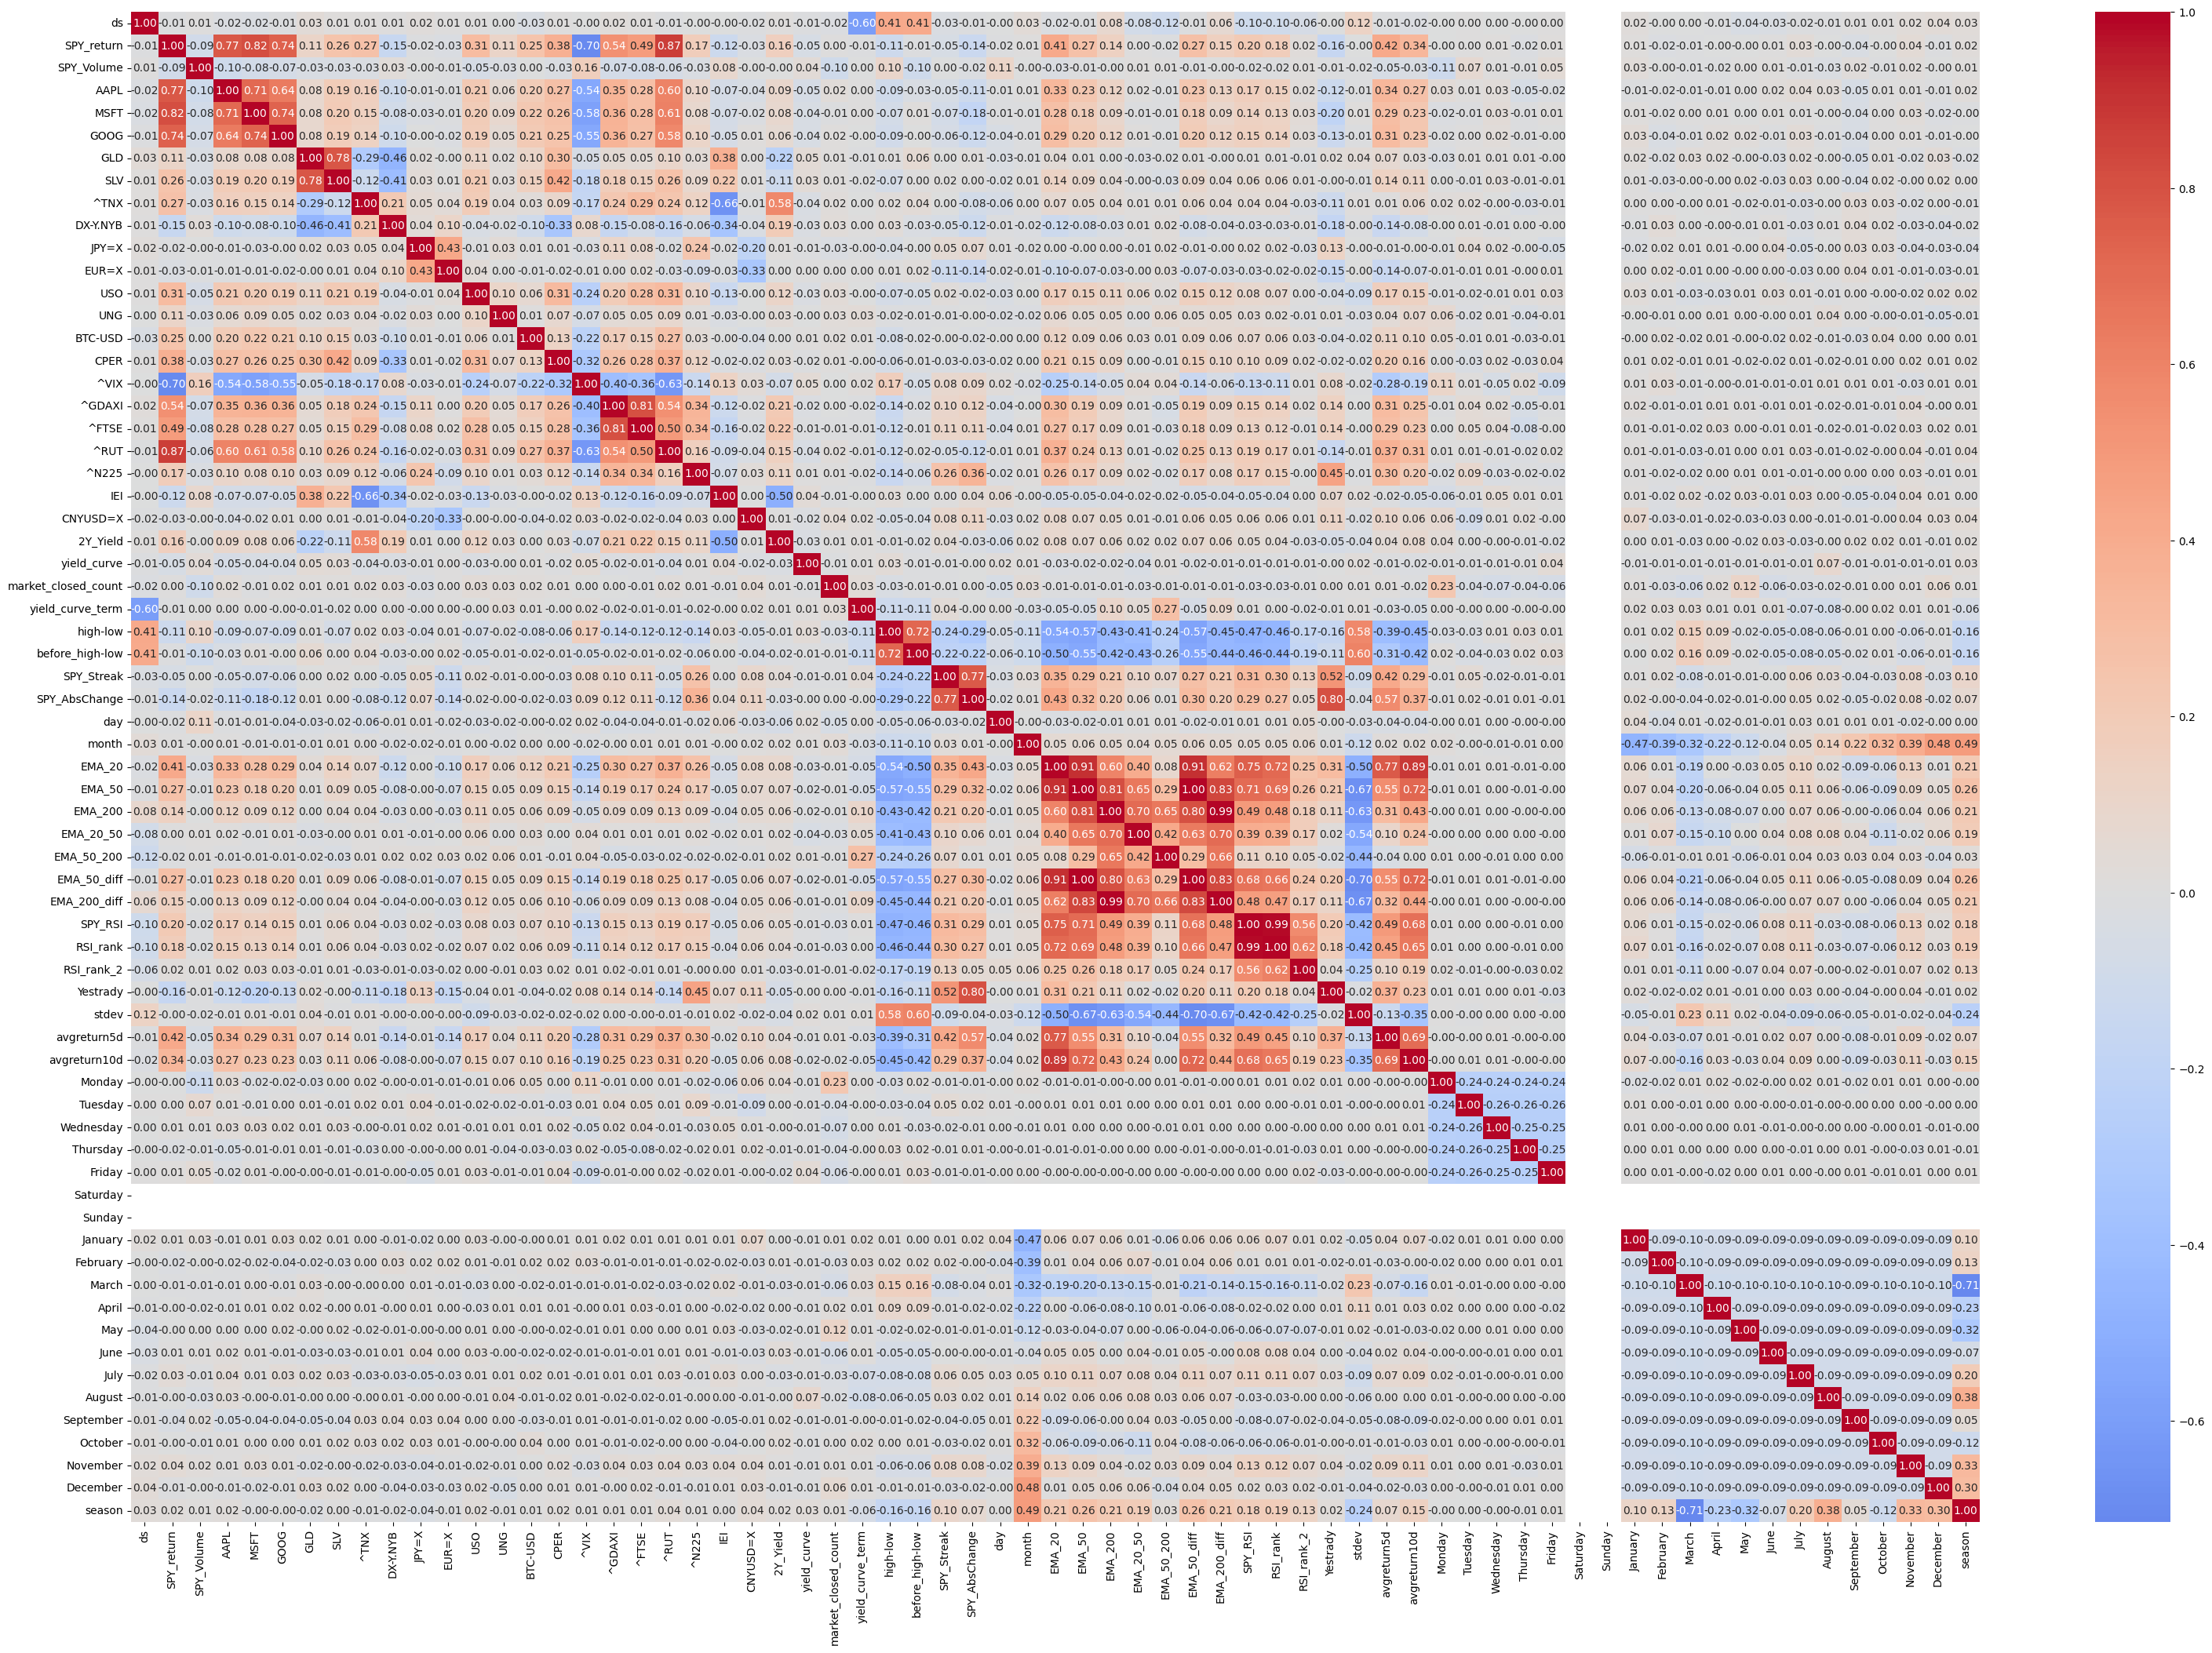

In [208]:
import matplotlib.pyplot as plt
plt.figure(figsize=(38, 25))
sns.heatmap(df_season.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.show()


In [201]:
x_c = df_season.drop(['SPY_return','ds'], axis=1)
cols = x_c.select_dtypes('float64').columns.to_list()
x_c = x_c[cols]
x_c.info()
y_c = df_season['SPY_return']



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SPY_Volume        1315 non-null   float64
 1   AAPL              1315 non-null   float64
 2   MSFT              1315 non-null   float64
 3   GOOG              1315 non-null   float64
 4   GLD               1315 non-null   float64
 5   SLV               1315 non-null   float64
 6   ^TNX              1315 non-null   float64
 7   DX-Y.NYB          1315 non-null   float64
 8   JPY=X             1315 non-null   float64
 9   EUR=X             1315 non-null   float64
 10  USO               1315 non-null   float64
 11  UNG               1315 non-null   float64
 12  BTC-USD           1315 non-null   float64
 13  CPER              1315 non-null   float64
 14  ^VIX              1315 non-null   float64
 15  ^GDAXI            1315 non-null   float64
 16  ^FTSE             1315 non-null   float64


In [203]:
# Step 1: Calculate correlation of each feature with y
correlations = x_c.corrwith(y_c)

# Step 2: Filter features based on the condition
mask = (correlations > 0.7) | (correlations < -0.15)
filtered_x = x_c.loc[:, mask]

# Optional: See what was kept
selected_corr_features = correlations[mask]
print("Selected features based on correlation threshold:")
print(selected_corr_features.sort_values())


Selected features based on correlation threshold:
^VIX         -0.698509
SPY_Volume   -0.259173
DX-Y.NYB     -0.216724
GOOG          0.740372
AAPL          0.781695
MSFT          0.814388
IWM           0.866553
dtype: float64


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract


# Grid search

In [205]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer

In [ ]:
# Param grids
rf_param_grid = {
    'n_estimators': [150,200,300],
    'max_features': [ None,'sqrt', 'log2',1.0],
    'max_depth': [None ,20, 30, 40, 70],
    'min_samples_split': [1,2,5,8],
    'min_samples_leaf': [1,2, 4, 8]
}

xgb_param_grid = {
    'n_estimators': [200,300],
    'max_depth': [5,7,8,9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6,0.8,1],
    'gamma':[0, 0.1, 0.3],
    'reg_alpha':[0, 0.1]
}
# the 100 trees not yielding the best resault therefore I can exclude them from the search

In [226]:


# Create custom scorer to minimize MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# TimeSeriesSplit (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)



# Fit Random Forest
rf_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                       param_grid=rf_param_grid,
                       cv=tscv,
                       scoring=mae_scorer,
                       verbose=1)

rf_grid.fit(x_train_ind, y_train_ind)

best_rf = rf_grid.best_estimator_



# Evaluate
rf_mae = mean_absolute_error(y_test_ind, best_rf.predict(x_test_ind))


print(f"✅ Best RF MAE: {rf_mae:.4f} → Params: {rf_grid.best_params_}")



Fitting 5 folds for each of 960 candidates, totalling 4800 fits


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1200 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    v

✅ Best RF MAE: 0.2309 → Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


# Grid with wights

In [ ]:
# Recreate sample weights using best_w
num_samples = len(y_train_ind2)
weights = np.linspace(1, 1.4, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1

# TimeSeriesSplit (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)


# Fit XGBoost
xgb_grid = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
                        param_grid=xgb_param_grid,
                        cv=tscv,
                        scoring=mae_scorer,
                        verbose=1)

xgb_grid.fit(x_train_ind2, y_train_ind2,sample_weight=weights )
best_xgb = xgb_grid.best_estimator_
# Evaluate
xgb_mae = mean_absolute_error(y_test_ind2, best_xgb.predict(x_test_ind2))

print(f"✅ Best XGB MAE: {xgb_mae:.4f} → Params: {xgb_grid.best_params_}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
✅ Best XGB MAE: 0.2191 → Params: {'learning_rate': 0.05, 'max_depth': 5, 'mean_samples_leaf': 1, 'n_estimators': 100, 'subsample': 0.8}


# XGBoost for wights and hyper parameters

In [1442]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Define candidate weight scalings to search over
w_candidates = np.arange(1.0, 3.1, 0.2)  # Try from 1.0 to 3.0 in steps of 0.2

best_mae = float('inf')
best_xgb_model = None
best_w = None
best_params = None

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for w in w_candidates:
    print(f"\n🔍 Testing weight slope: {w:.2f}")
    
    # Create weights linearly increasing from 1 to w
    num_samples = len(y_train_ind2)
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Grid search
    xgb_grid = GridSearchCV(
        XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
        param_grid=xgb_param_grid,
        cv=tscv,
        scoring=mae_scorer,
        verbose=0
    )

    xgb_grid.fit(x_train_ind2, y_train_ind2, sample_weight=weights)
    model = xgb_grid.best_estimator_

    # Evaluate on test set
    preds = model.predict(x_test_ind2)
    mae = mean_absolute_error(y_test_ind2, preds)
    print(f"→ MAE: {mae:.4f} | Best Params: {xgb_grid.best_params_}")

    if mae < best_mae:
        best_mae = mae
        best_xgb_model = model
        best_w = w
        best_params = xgb_grid.best_params_

# 🎉 Final result
print(f"\n✅ Best XGBoost Model")
print(f"MAE: {best_mae:.4f}")
print(f"Weight slope (w): {best_w}")
print(f"Hyperparameters: {best_params}")



🔍 Testing weight slope: 1.00
→ MAE: 0.2804 | Best Params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 0.6}

🔍 Testing weight slope: 1.20
→ MAE: 0.2643 | Best Params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.40
→ MAE: 0.2646 | Best Params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.60
→ MAE: 0.2725 | Best Params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6}

🔍 Testing weight slope: 1.80
→ MAE: 0.2783 | Best Params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6}

🔍 Testing weight slope: 2.00
→ MAE: 0.2691 | Best Params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0

# Adding weights to xgboost

In [ ]:


# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, n_jobs=-1)
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight slope w={best_w:.2f} with MAE={best_mae:.4f}")
